# Amazon SageMaker - Bring Your Own Model 
## Chainer 編

ここでは [Chainer](https://chainer.org/) のサンプルコードをAmazon SageMaker 上で実行するための移行手順について説明します。SageMaker Python SDK で Chainer を使うための説明は [SDK のドキュメント](https://sagemaker.readthedocs.io/en/stable/using_chainer.html) にも多くの情報があります。

注: 
ここでは以降手順の紹介のためトレーニングスクリプトは最小限の書き換えとしています。

## 1. トレーニングスクリプトの書き換え

### 書き換えが必要な理由
Amazon SageMaker では、オブジェクトストレージ Amazon S3 をデータ保管に利用します。例えば、S3 上の学習データを指定すると、自動的に  Amazon SageMaker の学習用インスタンスにデータがダウンロードされ、トレーニングスクリプトが実行されます。トレーニングスクリプトを実行した後に、指定したディレクトリにモデルを保存すると、自動的にモデルがS3にアップロードされます。

トレーニングスクリプトを SageMaker に持ち込む場合は、以下の点を修正する必要があります。
- 学習用インスタンスにダウンロードされた学習データのロード
- 学習が完了したときのモデルの保存

これらの修正は、トレーニングスクリプトを任意の環境に持ち込む際の修正と変わらないでしょう。例えば、自身のPCに持ち込む場合も、`/home/user/data` のようなディレクトリからデータを読み込んで、`/home/user/model` にモデルを保存したいと考えるかもしれません。同様のことを SageMaker で行う必要があります。

### 書き換える前に保存先を決める

このハンズオンでは、S3からダウンロードする学習データ・バリデーションデータと、S3にアップロードするモデルは、それぞれ以下のように学習用インスタンスに保存することにします。`/opt/ml/input/data/train/`といったパスに設定することは奇異に感じられるかもしれませんが、これらは環境変数から読み込んで使用することが可能なパスで、コーディングをシンプルにすることができます。[1-1. 環境変数の取得](#env)で読み込み方法を説明します。

#### 学習データ
- 画像: `/opt/ml/input/data/train/train.npz`

#### バリデーションデータ
- 画像: `/opt/ml/input/data/test/test.npz`

#### モデル
`/opt/ml/model` 以下にシンボルやパラメータを保存する

### 書き換える箇所
まず [サンプルのソースコード](https://raw.githubusercontent.com/chainer/chainer/v5/examples/mnist/train_mnist.py) を以下のコマンドでダウンロードします。

In [32]:
!wget https://raw.githubusercontent.com/chainer/chainer/v5/examples/mnist/train_mnist.py

--2019-11-16 05:08:28--  https://raw.githubusercontent.com/chainer/chainer/v5/examples/mnist/train_mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4913 (4.8K) [text/plain]
Saving to: ‘train_mnist.py’

train_mnist.py      100%[===================>]   4.80K  --.-KB/s    in 0.001s  

2019-11-16 05:08:29 (6.54 MB/s) - ‘train_mnist.py’ saved [4913/4913]



ダウンロードされた `train_mnist.py` をファイルブラウザから見つけて開いて下さい (JupyterLab の場合は左右にファイルを並べると作業しやすいです)。あるいはお好きなエディターをお使い頂いても結構です。この`train_mnist.py`は、トレーニングスクリプト内で以下の関数を呼び出し、S3以外からデータをダウンロードしています。

学習データをダウンロードして、前述したように`/opt/ml/input/data/train/`といったパスから読み出して使います。書き換える点は主に3点です:
1. 環境変数の取得  
    SageMaker では、学習データやモデルの保存先はデフォルトで指定されたパスがあり、これらを環境変数から読み込んで使用することが可能です。環境変数を読み込むことで、学習データの位置をトレーニングスクリプト内にハードコーディングする必要がありません。もちろんパスの変更は可能で、API経由で渡すこともできます。
    
1. 学習データのロード  
    環境変数を取得して学習データの保存先がわかれば、その保存先から学習データをロードするようにコードを書き換えましょう。

1. 学習済みモデルの保存形式と出力先の変更  
    SageMaker では Chainer の Estimator に対して deploy 関数を呼び出すことによってモデルをデプロイします。もとの`train_mnist.py`では、デプロイに十分な情報がありません。このサンプルでは npz 形式を使用するため、npz 形式でモデルが保存されるようにコードを追加します。その際、モデルの保存先を正しく指定する必要があります。学習が完了すると学習用インスタンスは削除されますので、保存先を指定のディレクトリに変更して、モデルがS3にアップロードされるようにします。

### <a name="env"></a>1-1. 環境変数の取得

Amazon SageMaker では、トレーニングに用いるコードが実行時に Python スクリプトとして実行されます。その際、データ・モデルの入出力は [こちら](https://sagemaker.readthedocs.io/en/stable/using_chainer.html#prepare-a-chainer-training-script) に記述があるよう `SM_CHANNEL_XXXX` や `SM_MODEL_DIR` という環境変数を参照する必要があります。そのため、`argparse.ArgumentParser` で渡された環境変数と、スクリプト実行時のハイパーパラメータを取得します。

![データのやりとり](./sagemaker-data-model.png)

`SM_CHANNEL_TRAIN`, `SM_CHANNEL_TEST`, `SM_MODEL_DIR` の環境変数の値を取得するよう、以下の関数をトレーニングスクリプトの最初に追加します。この関数はデフォルトでこれらの環境変数を、`args.train`、`args.test`、`args.sm_model_dir` に格納します。また、 `SM_MODEL_DIR` は `model_dir` とは異なり、`args.model_dir` には常に S3 のパスが渡されます。

```python
def parse_args():
  parser = argparse.ArgumentParser()
  parser.add_argument('--train', type=str, default=os.environ['SM_CHANNEL_TRAIN'])
  parser.add_argument('--test', type=str, default=os.environ['SM_CHANNEL_TEST'])
  parser.add_argument('--sm-model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
  parser.add_argument('--training-steps', type=int, default=20000)
  args, _ = parser.parse_known_args()
  return args
```


これらの値は、create-training-jobのAPIを実行する際に (SageMaker Python SDK で estimator を呼び出す際に) 指定した hyperparameters の値に置き換えることができます。例えば、hyperparameters に `train`、`test`、`sm-model-dir`が指定されていれば、環境変数の値は hyperparameters の値で上書きされます。ここでは、学習のステップ数 `training-steps` はデフォルトで20000という値にしておいて、学習実行時に hyperparameters 経由で変更できるようにしておきましょう。そうすることで、デバッグ時に小さい training-steps で実行したりすることができます。


`train_mnist.py`は、`if __name__ == "__main__":`から`main():`を実行します。最初に読み込むために、上記で定義した`parse_args()`を`main()`の冒頭に挿入して、`args`の中身を取り出します。このような記述になります。

```python
def main():
  args = parse_args()
  train_dir = args.train
  test_dir = args.test
  sm_model_dir = args.sm_model_dir
  training_steps = args.training_steps
```

これで学習データ・バリデーションデータの保存先を取得することができました。次にこれらのファイルを実際に読み込む処理を実装します。

#### 確認
これまでに、train_mnist.py に対して以下の変更を行いました。
* parse_args() 関数の追加
* main() 関数の始めに環境編集取得の記述を追加

### 1-2. 学習データのロード

train_mnist.py の先頭に、以下の記述を追加して必要はモジュールを import します。
```python
import numpy as np
import os
```

もともとある以下の部分を、
```python
from chainer import training
```
以下のように追記します。
```python
from chainer import training, serializers
```

S3からダウンロードしたデータを読み込みコードを実装しましょう。環境変数から取得した `train_dir`や`test_dir` にデータを保存したディレクトリへのパスが保存され、それぞれ `/opt/ml/input/data/train`, `/opt/ml/input/data/test` となります。詳細は [ドキュメント](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo-running-container.html#your-algorithms-training-algo-running-container-trainingdata) をご覧下さい。

今回は npz ファイルを読むようにコードを書き換えるので、以下のようなコードを main() 関数に追記します。パスが `train_dir`, `test_dir` に保存されていることをうまく利用しましょう。
まずは、もともとある以下のコードをコメントアウトします。こちらは、mnistのデータを取得している部分です。
```python
# train, test = chainer.datasets.get_mnist()　#を先頭につけるとコメントアウトされます。
```
コメントアウトした部分の下に以下のコードを追記します。ここで、S3からダウンロードしたデータを読み込みます。
```python
    train_data = np.load(os.path.join(train_dir, 'train.npz'))['images']
    train_labels = np.load(os.path.join(train_dir, 'train.npz'))['labels']

    test_data = np.load(os.path.join(test_dir, 'test.npz'))['images']
    test_labels = np.load(os.path.join(test_dir, 'test.npz'))['labels']

    train = chainer.datasets.TupleDataset(train_data, train_labels)
    test = chainer.datasets.TupleDataset(test_data, test_labels)
```

main() 関数の一番最後に、学習したモデルを保存するための以下の記述を追加します。
```python
serializers.save_npz(os.path.join(sm_model_dir, 'model.npz'), model)
```


#### 確認
これまでに、train_mnist.py に以下の変更を行いました。
* import の追加（numpy, os, serializers）
* main() 関数の mnist のデータを取得する部分をコメントアウト
* main() 関数に S3からダウンロードしたデータを読み込む記述を追加
* main() 関数の最後にモデルを保存する記述を追加

### 1-3. 推論用の関数を追加

main() 関数の下に、以下の関数を追加します。こちらは、推論エンドポイントを立てる際に呼び出される関数です。
```python
def model_fn(model_dir):
    model = L.Classifier(MLP(1000, 10))
    serializers.load_npz(os.path.join(model_dir, 'model.npz'), model)
    return model.predictor
```

## 2. Notebook 上でのデータ準備

トレーニングスクリプトの書き換えは終了しました。　学習を始める前に、予め Amazon S3 にデータを準備しておく必要があります。この Notebook を使ってその作業をします。

In [1]:
import os
import numpy as np
import boto3
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

機械学習に利用する手書き数字データセットの MNIST を利用します。`chainer.datasets.get_mnist`を利用してデータセットをダウンロードし、学習用と検証用のデータをそれぞれ npz 形式で保存します。

In [7]:
import chainer
import shutil

# Download MNIST dataset
train, test = chainer.datasets.get_mnist()

# Extract data and labels from dataset 
train_images = np.array([data[0] for data in train])
train_labels = np.array([data[1] for data in train])
test_images = np.array([data[0] for data in test])
test_labels = np.array([data[1] for data in test])

# Save the data and labels as .npz into local directories and upload them to S3

os.makedirs('data/train')
os.makedirs('data/test')

np.savez('data/train/train.npz', images=train_images, labels=train_labels)
np.savez('data/test/test.npz', images=test_images, labels=test_labels)

    

これを Amazon S3 にアップロードします。

In [10]:
train_data = sagemaker_session.upload_data(path='data/train', key_prefix='data/handson-chainer-mnist-byom/train')
test_data = sagemaker_session.upload_data(path='data/test', key_prefix='data/handson-chainer-mnist-byom/test')

## 3. Local Mode によるトレーニングとコードの検証
トレーニングジョブを始める前に、Local Mode を使って、この Notebook インスタンス上でコンテナを実行してコードをデバッグしましょう。
`from sagemaker.chainer.estimator import Chainer` で読み込んだ SageMaker Python SDK の Chainer Estimator を作ります。

ここでは、学習に利用するインスタンス数 `train_instance_count` や  インスタンスタイプ `train_instance_type` を指定します。Local modeの場合は、`train_instance_type = "local"` と指定します。

デバッグなので多くの学習ステップを回す必要はありません。`epoch` に 3 を設定します。

In [82]:
import subprocess

from sagemaker.chainer.estimator import Chainer

# instance_type = 'ml.m4.xlarge'
instance_type = 'local'

chainer_estimator = Chainer(entry_point='train_mnist.py', role=role,
                            train_instance_count=1, train_instance_type=instance_type,
                            framework_version='5.0.0',
                            hyperparameters={'epoch': 3, 'batchsize': 128})



`estimator.fit` によりトレーニングを開始しますが、ここで指定する「チャネル」によって、環境変数名 `SM_CHANNEL_XXXX` が決定されます。この例の場合、`'train', 'test'` を指定しているので、`SM_CHANNEL_TRAIN`, `SM_CHANNEL_TEST` となります。

In [83]:
chainer_estimator.fit({'train': train_input, 'test': test_input})

# Keep the job name for checking training loss later 
training_job = chainer_estimator.latest_training_job.name

Creating tmpub4ekill_algo-1-3zmoe_1 ... 
Attaching to tmpub4ekill_algo-1-3zmoe_12mdone
algo-1-3zmoe_1  | 2019-11-16 09:27:15,485 sagemaker-containers INFO     Imported framework sagemaker_chainer_container.training
algo-1-3zmoe_1  | 2019-11-16 09:27:15,488 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-3zmoe_1  | 2019-11-16 09:27:15,631 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
algo-1-3zmoe_1  | Generating setup.py
algo-1-3zmoe_1  | 2019-11-16 09:27:15,631 sagemaker-containers INFO     Generating setup.cfg
algo-1-3zmoe_1  | 2019-11-16 09:27:15,631 sagemaker-containers INFO     Generating MANIFEST.in
algo-1-3zmoe_1  | 2019-11-16 09:27:15,631 sagemaker-containers INFO     Installing module with the following command:
algo-1-3zmoe_1  | /usr/bin/python3.6 -m pip install -U . 
algo-1-3zmoe_1  | Processing /tmp/tmph6m5kbxp/module_dir
algo-1-3zmoe_1  | Building wheels for collected packages: default-user-mo

algo-1-3zmoe_1  | GPU: -1
algo-1-3zmoe_1  | # unit: 1000
algo-1-3zmoe_1  | # Minibatch-size: 128
algo-1-3zmoe_1  | # epoch: 3
algo-1-3zmoe_1  | 
algo-1-3zmoe_1  | epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
algo-1-3zmoe_1  |      total [###...............................................]  7.11%
algo-1-3zmoe_1  | this epoch [##########........................................] 21.33%
algo-1-3zmoe_1  |        100 iter, 0 epoch / 3 epochs
algo-1-3zmoe_1  |        inf iters/sec. Estimated time to finish: 0:00:00.
algo-1-3zmoe_1  |      total [#######...........................................] 14.22%
algo-1-3zmoe_1  | this epoch [#####################.............................] 42.67%
algo-1-3zmoe_1  |        200 iter, 0 epoch / 3 epochs
algo-1-3zmoe_1  |     32.073 iters/sec. Estimated time to finish: 0:00:37.608931.
algo-1-3zmoe_1  |      total [##########........................................] 21.33%
algo-1-3zmoe_1  | this epoc

`cnn_mnist.py` の中で書き換えを忘れた部分があったら、ここでエラーとなる場合があります。Local Mode ではクイックにデバッグができるので、正しく実行できるよう試行錯誤しましょう。

 `===== Job Complete =====`
と表示されれば成功です。

### 学習済みモデルの確認

Amazon S3 に保存されたモデルは普通にダウンロードして使うこともできます。保存先は `chainer_estimator.model_data` で確認できます。

In [45]:
chainer_estimator.model_data

's3://sagemaker-us-east-1-420964472730/sagemaker-chainer-2019-11-16-05-35-10-834/model.tar.gz'

AWS CLI を使ってノートブックインスタンス上にモデルをダウンロードして試しに推論します。

このノートブックと同じディレクトリに tar.gz の形式でモデルをダウンロードして展開します。展開後のディレクトリ名は数字の羅列 (Unix time) になります。あとでモデルを読み込むため、正規表現を利用して、このフォルダ名を `model_dir` に保存します。

In [84]:
!aws s3 cp $chainer_estimator.model_data ./
!tar -zxvf ./model.tar.gz

download: s3://sagemaker-us-east-1-420964472730/sagemaker-chainer-2019-11-16-09-27-08-516/model.tar.gz to ./model.tar.gz
model.npz


In [47]:
# import re    
# dir_list = os.listdir(".")
# pattern = "[0-9]+"
# for d in dir_list:
#     if re.match(pattern,d):
#         model_dir = d
#         print("model is downloaded to ./{}".format(model_dir))

テストデータセットからランダムに10枚選んでテストを行います。先ほど保存した`model_dir`からモデルをロードして、テストデータを入力します。ローカルモードでは学習を少ししか実行しなかったため、ほとんど正しい予測はできていないかもしれません。

まずはロードするモデルを格納するためのモデルを定義し、モデルをロードします。

In [85]:
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)
    
model = L.Classifier(MLP(1000, 10))
chainer.serializers.load_npz('model.npz', model)


次に、ロードした学習済みモデルを使って推論を行います。

The predicted labels are: [5 2 9 2 2 2 8 7 0 7]


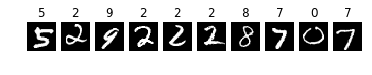

In [86]:

%matplotlib inline
import random

import matplotlib.pyplot as plt

num_samples = 10
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images, labels = test_images[indices], test_labels[indices]


for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

with chainer.using_config('train', False):
    prediction = model.predictor(images)
    

predicted_label = prediction.data.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

## 4. トレーニングジョブの発行

推論されていればコードのデバッグは完了です。次に、Amazon SageMaker のトレーニングジョブとしてトレーニングします。データ・モデルの入出力は変わらず S3 なので、`train_instance_type` に `ml.` で始まる SageMaker のインスタンスを指定するだけで実行できます。(リストは[こちら](https://aws.amazon.com/sagemaker/pricing/instance-types/))

In [76]:
instance_type = "ml.m4.xlarge"

chainer_estimator = Chainer(entry_point='train_mnist.py', role=role,
                            train_instance_count=1, train_instance_type=instance_type,
                            framework_version='5.0.0',
                            hyperparameters={'epoch': 3, 'batchsize': 128})

In [77]:
chainer_estimator.fit({'train': train_data, 'test': test_data})

2019-11-16 08:34:20 Starting - Starting the training job...
2019-11-16 08:34:22 Starting - Launching requested ML instances......
2019-11-16 08:35:28 Starting - Preparing the instances for training......
2019-11-16 08:36:48 Downloading - Downloading input data
2019-11-16 08:36:48 Training - Downloading the training image...
2019-11-16 08:37:06 Training - Training image download completed. Training in progress...2019-11-16 08:37:07,307 sagemaker-containers INFO     Imported framework sagemaker_chainer_container.training
2019-11-16 08:37:07,310 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2019-11-16 08:37:07,600 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 
Generating setup.py
2019-11-16 08:37:07,600 sagemaker-containers INFO     Generating setup.cfg
2019-11-16 08:37:07,601 sagemaker-containers INFO     Generating MANIFEST.in
2019-11-16 08:37:07,601 sagemaker-containers INFO     Installing module with the follo

#033[4A#033[J     total [################################..................] 64.00%
this epoch [##############################################....] 92.00%
       900 iter, 1 epoch / 3 epochs
    21.799 iters/sec. Estimated time to finish: 0:00:23.223282.
#033[4A#033[J2           0.0746589   0.0755269             0.977162       0.97587                   44.2882       
#033[J     total [###################################...............] 71.11%
this epoch [######............................................] 13.33%
      1000 iter, 2 epoch / 3 epochs
    21.067 iters/sec. Estimated time to finish: 0:00:19.284128.
#033[4A#033[J     total [#######################################...........] 78.22%
this epoch [#################.................................] 34.67%
      1100 iter, 2 epoch / 3 epochs
    20.975 iters/sec. Estimated time to finish: 0:00:14.600473.
#033[4A#033[J     total [##########################################........] 85.33%
this epoch [############################...

----
```
Billable seconds: <time>
```
と出力されればトレーニング終了です。これが実際にトレーニングインスタンスが課金される時間となります。

## 5. 推論エンドポイントのデプロイ

`chainer_estimator.deploy` で、トレーニングしたモデルを推論エンドポイントとしてデプロイすることができます。これには数分かかります。(`----!` と表示されればデプロイ完了です。)

In [78]:
predictor = chainer_estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

---------------------------------------------------------------------------------------------------!

The predicted labels are: [6 9 7 3 5 0 0 2 3 4]


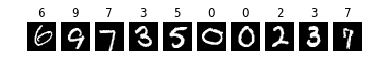

In [79]:
%matplotlib inline
import random

import matplotlib.pyplot as plt

num_samples = 10
indices = random.sample(range(test_images.shape[0] - 1), num_samples)
images, labels = test_images[indices], test_labels[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')

prediction = predictor.predict(images)
predicted_label = prediction.argmax(axis=1)
print('The predicted labels are: {}'.format(predicted_label))

In [72]:
!wget https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-examples-jp/master/chainer_mnist/input.html
from IPython.display import HTML
HTML(open("input.html").read())

--2019-11-16 08:33:25--  https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-examples-jp/master/chainer_mnist/input.html
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.248.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.248.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13304 (13K) [text/plain]
Saving to: ‘input.html’

input.html          100%[===================>]  12.99K  --.-KB/s    in 0.001s  

2019-11-16 08:33:25 (17.4 MB/s) - ‘input.html’ saved [13304/13304]



In [81]:
image = np.array(data, dtype=np.float32)
prediction = predictor.predict(image)
predicted_label = prediction.argmax(axis=1)[0]
print('What you wrote is: {}'.format(predicted_label))

What you wrote is: 4


推論エンドポイントは立てっぱなしにしているとお金がかかるので、確認が終わったら忘れないうちに削除してください。

In [ ]:
predictor.delete_endpoint()

## 6. まとめ

Chainer を使った Amazon SageMaker への移行手順について紹介しました。普段お使いのモデルでも同様の手順で移行が可能ですのでぜひ試してみてください。